In [1]:
# Use svg graphics, display inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Basic preprocessing, regression, classification, validation
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LogisticRegressionCV, LogisticRegression

# Hex colors for plotting
FB_BLUE = '#1877F2'
FB_HERITAGE_BLUE = '#3b5998'
FB_LIGHT_BLUE = '#8b9dc3'
FB_VERY_LIGHT_BLUE = '#dfe3ee'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'

# display config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = 10, 6
np.set_printoptions(suppress=True)

print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


Data is from the [Washington state COVID dashboard](https://www.doh.wa.gov/Emergencies/NovelCoronavirusOutbreak2020COVID19/DataDashboard). Under the Testing tab, click the orange download button

In [209]:
df = pd.read_csv('data/PUBLIC_Tests_by_Speciment_Collection.csv')
df.columns = 'county|date|pos|pos_incomplete|neg|neg_incomplete|perc_county_pos'.split('|')
df['date'] = pd.to_datetime(df.date)
df['days_since_first'] = (df.date - df.date[0]).dt.days.values
df['total_tests'] = [sum(row[2:6]) for row in df.values]
df.head()

,county,date,pos,pos_incomplete,neg,neg_incomplete,perc_county_pos,days_since_first,total_tests
0,Adams County,2020-02-29,0,0,0,0,-,0,0
1,Adams County,2020-03-01,0,0,0,0,-,1,0
2,Adams County,2020-03-02,0,0,0,0,-,2,0
3,Adams County,2020-03-03,0,0,0,0,-,3,0
4,Adams County,2020-03-04,0,0,0,0,-,4,0


In [210]:
perc_inc_daily[-10:]

date
2020-06-21     nan
2020-06-22     nan
2020-06-23     nan
2020-06-24   0.045
2020-06-25   0.047
2020-06-26   0.038
2020-06-27   0.046
2020-06-28   0.041
2020-06-29   0.032
2020-06-30   0.034
dtype: float64

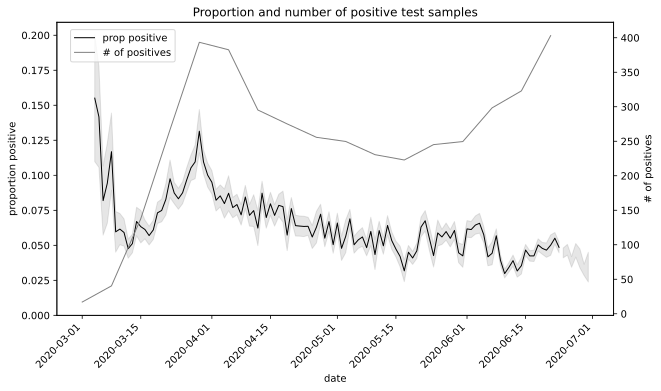

In [211]:
def plot_perc_violating(df): 
    pos_daily = df.groupby('date').pos.sum()
    total_daily = df.groupby('date').pos.sum() + df.groupby('date').neg.sum()
    perc_daily = pos_daily / total_daily
    std_dev_daily = np.sqrt(perc_daily * (1 - perc_daily) / total_daily)
    perc_daily_upper_ci = perc_daily + 1.96 * std_dev_daily
    perc_daily_lower_ci = perc_daily - 1.96 * std_dev_daily

    pos_inc_daily = df.groupby('date').pos_incomplete.sum()
    total_inc_daily = df.groupby('date').pos_incomplete.sum() + df.groupby('date').neg_incomplete.sum()
    perc_inc_daily = pos_inc_daily / total_inc_daily
    std_dev_inc_daily = np.sqrt(perc_inc_daily * (1 - perc_inc_daily) / total_inc_daily)
    perc_daily_inc_upper_ci = perc_inc_daily + 1.96 * std_dev_inc_daily
    perc_daily_inc_lower_ci = perc_inc_daily - 1.96 * std_dev_inc_daily


    lw = 1.

    fig, ax_1 = plt.subplots()

    line_1 = ax_1.plot(perc_daily[4:], linewidth=lw, color='black', label='prop positive')
    ax_1.fill_between(
        perc_daily_lower_ci[4:].index, 
        perc_daily_lower_ci[4:], 
        perc_daily_upper_ci[4:], 
        color='black',
        linewidth=lw_ci,
        alpha=.1
    )

#     ax_1.plot(perc_inc_daily[4:], color='orange', linewidth=lw, label='incomplete data')
    ax_1.fill_between(
        perc_daily_inc_lower_ci[4:].index, 
        perc_daily_inc_lower_ci[4:], 
        perc_daily_inc_upper_ci[4:], 
        color='black',
        alpha=.1
    )

    fig.autofmt_xdate(rotation=45)
    ax_1.set_ylim([0,None])

    ax_1.set_xlabel('date')
    ax_1.set_ylabel('proportion positive')

    # plot daily volume
    
    ax_2 = ax_1.twinx()
    line_2 = ax_2.plot((pos_daily + pos_inc_daily).resample('W').mean()[:-2], linewidth=lw, color='grey', label='# of positives')
    ax_2.set_ylabel('# of positives')

    # if we're only looking at one county, put its name in the title
    if df.county.unique().shape[0] == 1:
        county_name = df.county.unique()[0]
        ax_1.set_title(f'[{county_name}] Proportion of positive test samples by date')
    else:
        ax_1.set_title(f'Proportion and number of positive test samples')
        
    fig.legend(loc='upper right', bbox_to_anchor=(0.25, 0.85))

    plt.show()
    
plot_perc_violating(df)

In [215]:
pos_daily = df.groupby('date').pos.sum()
total_daily = df.groupby('date').pos.sum() + df.groupby('date').neg.sum()
perc_daily = pos_daily / total_daily

# this is hacky
days_since_first = df.groupby('date').days_since_first.mean()

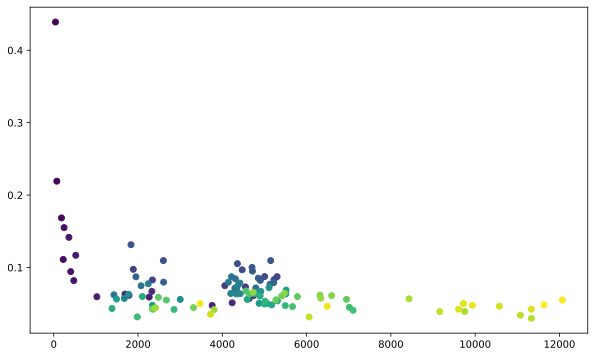

In [216]:
plt.scatter(total_daily, perc_daily, c=days_since_first)

In [235]:
df_daily = pd.DataFrame(data={
    'pos': pos_daily,
    'total': total_daily,
    'perc': perc_daily
}).dropna()

df_daily['perc_is_high'] = df_daily.perc >= df_daily.perc.median()
df_daily['total_is_high'] = df_daily.total >= 2000
df_daily.head()

,pos,total,perc,perc_is_high,total_is_high
date,,,,,
2020-02-29,18,41,0.439,True,False
2020-03-01,16,73,0.219,True,False
2020-03-02,31,184,0.168,True,False
2020-03-03,25,225,0.111,True,False
2020-03-04,38,245,0.155,True,False


In [236]:
df_daily.groupby('total_is_high').perc.agg(lambda x: np.mean(x))

total_is_high
False   0.112
True    0.062
Name: perc, dtype: float64

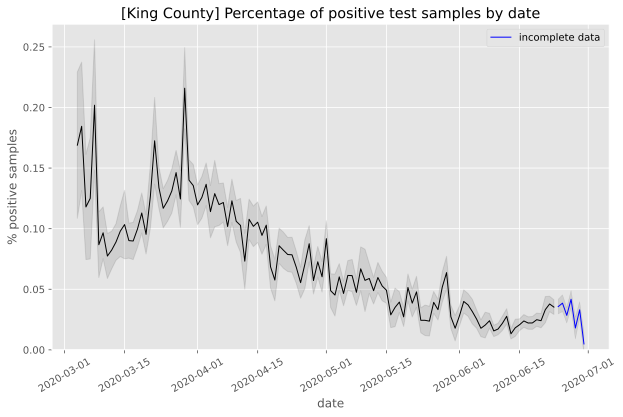

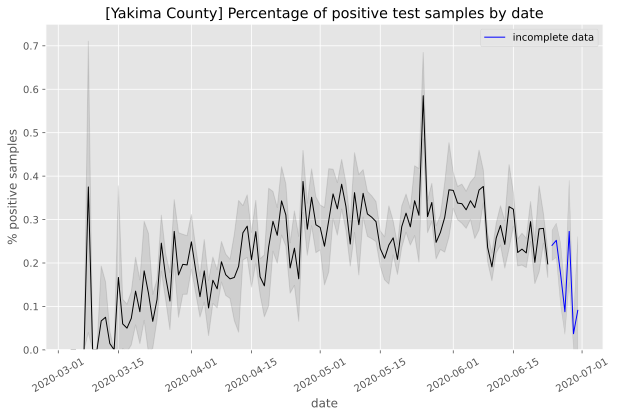

In [126]:
for county in ('King', 'Yakima'):
    plot_perc_violating(df[df.county == f'{county} County'])

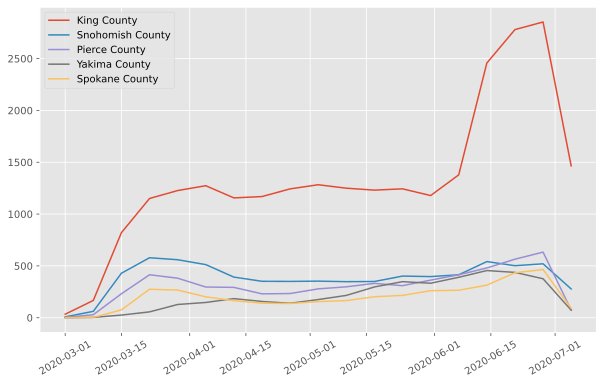

In [116]:
counts = sorted(df.groupby('county').total_tests.sum().items(), key=lambda x: -x[1])
top_counties = [x[0] for x in counts if x[0] != 'Unassigned'][:5]

with plt.style.context('ggplot'):
    for county in top_counties:
        df_temp = df[df.county == county]
        data = df_temp.groupby('date').total_tests.sum().resample('W').mean()

        plt.plot(data, label=county)
        plt.xticks(rotation=30)
        plt.legend()


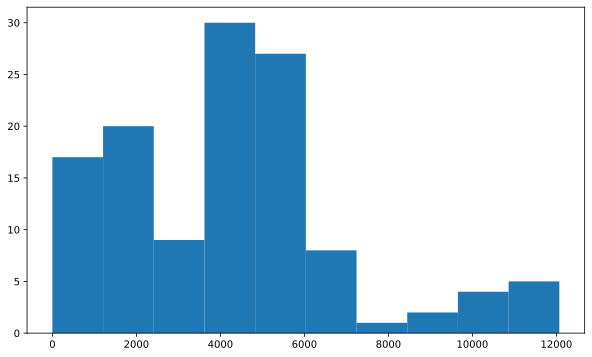

In [237]:
plt.hist(total_daily);